In [1]:
print('hello world')

hello world


In [48]:
import os
import random
import glob

import numpy as np
from PIL import Image, ImageDraw
import cv2
from skimage import transform as sktf

# -------------------------------------------------------------------
# 1. Central square mask
# -------------------------------------------------------------------
def central_mask(img_size, mask_frac=0.5):
    H, W = img_size
    mask_size = int(min(H, W) * mask_frac)
    y0 = (H - mask_size) // 2
    x0 = (W - mask_size) // 2
    mask = np.zeros((H, W), dtype=np.uint8)
    mask[y0:y0+mask_size, x0:x0+mask_size] = 1
    return mask

# -------------------------------------------------------------------
# 2. Random block masks
# -------------------------------------------------------------------
def random_block_mask(img_size, max_blocks=5, max_frac=0.25):
    H, W = img_size
    mask = np.zeros((H, W), dtype=np.uint8)
    area = H * W
    covered = 0
    while covered / area < max_frac and mask.sum() / area < max_frac:
        h = random.randint(H//10, H//3)
        w = random.randint(W//10, W//3)
        y0 = random.randint(0, H - h)
        x0 = random.randint(0, W - w)
        mask[y0:y0+h, x0:x0+w] = 1
        covered = mask.sum()
    return mask

In [92]:
# -------------------------------------------------------------------
# apply masks to an RGB image
# -------------------------------------------------------------------
def apply_mask(img_np, mask):
    # img_np: H×W×3, mask: H×W binary
    return img_np * (1 - mask[:, :, None])

In [ ]:
# -------------------------------------------------------------------
# full pipeline
# -------------------------------------------------------------------
def make_masks_for_image(img_path, voc_seg_dir):
    img = Image.open(img_path).convert('RGB')
    W, H = img.size
    img_np = np.array(img).astype(np.uint8) # (500, 486, 3) ndarray

    # print('w and h', W, H)
    # print(type(img_np))
    # print(img_np.shape)

    # 1) central
    # m1 = central_mask((H, W), mask_frac=0.5)
    # out1 = apply_mask(img_np, m1)
    # # Image.fromarray(out1).save(img_path.replace('.','_central.'))
    
    # output_dir = '/Users/ineshtandon/Documents/ML Projects/Image Repair/sample_data_central'
    # os.makedirs(output_dir, exist_ok=True)  # Create the folder if it doesn't exist

    # # Save the image in the new folder
    # Image.fromarray(out1).save(os.path.join(output_dir, os.path.basename(img_path).replace('.', '_central.')))

    # # 2) random blocks
    # m2 = random_block_mask((H, W), max_blocks=8, max_frac=0.25)
    # out2 = apply_mask(img_np, m2)
    # # Image.fromarray(out2).save(img_path.replace('.','_blocks.'))

    # output_dir = '/Users/ineshtandon/Documents/ML Projects/Image Repair/sample_data_blocks'
    # os.makedirs(output_dir, exist_ok=True)  # Create the folder if it doesn't exist

    # # Save the image in the new folder
    # Image.fromarray(out2).save(os.path.join(output_dir, os.path.basename(img_path).replace('.', '_block.')))

    # 3) random region
    output_dir = '/Users/ineshtandon/Documents/ML Projects/Image Repair/sample_data_regions'
    os.makedirs(output_dir, exist_ok=True)  # Create the folder if it doesn't exist

    masker = VOCShapeMasker(voc_seg_dir)
    m3 = masker.sample_region((H, W), img, output_dir) # random masker class call

    # dont need this random masker
    # # m3 = random_region_mask(H, W, voc_seg_dir) # alternate random masker

    # out3 = apply_mask(img_np, m3)
    # # Image.fromarray(out3).save(img_path.replace('.','_region.'))


    # # Save the image in the new folder
    # Image.fromarray(out3).save(os.path.join(output_dir, os.path.basename(img_path).replace('.', '_random.')))

# if __name__ == '__main__':
#     # Example usage:
#     IMG_DIR   = 'images/'
#     VOC_DIR   = 'VOC2012/SegmentationClass/'
#     for img_fp in glob.glob(os.path.join(IMG_DIR, '*.jpg')):
#         make_masks_for_image(img_fp, VOC_DIR)

In [ ]:
make_masks_for_image('/Users/ineshtandon/Documents/ML Projects/Image Repair/VOC2012/JPEGImages/2007_000027.jpg', '/Users/ineshtandon/Documents/ML Projects/Image Repair/VOC2012/SegmentationClass/')

In [131]:
# testing mask extraction:

import cv2
import numpy as np

def mask_extractor(mask_path):

    # 1. Load your color‑coded image.
    img = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)  # BGR

    # 2. Find all unique colors except black.
    pixels = img.reshape(-1, 3)
    uniq_colors = np.unique(pixels, axis=0)
    # Filter out black:
    colors = [tuple(c) for c in uniq_colors if not np.all(c == [0,0,0])]

    for idx, color in enumerate(colors):

        if color == (192,224,224):
            # found the boundary, skipping this boundary extraction
            continue

        # 3a. Create a mask for this color.
        mask = np.all(img == color, axis=2)  # shape (H,W), bool

        # 3b. Find bounding box of the True region.
        ys, xs = np.where(mask)
        if ys.size == 0:
            continue
        y1, y2 = ys.min(), ys.max()
        x1, x2 = xs.min(), xs.max()

        # 3c. Crop the image to the bounding box.
        crop_bgr = img[y1:y2+1, x1:x2+1]

        # 3d. Build an alpha channel from the mask.
        crop_mask = mask[y1:y2+1, x1:x2+1].astype(np.uint8) * 255
        crop_bgra = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2BGRA)
        crop_bgra[:, :, 3] = crop_mask

        crop_bgra[:,:,0:3] = 0 # setting color to black

        # 4. Save the result (transparent PNG).
        out_name = f'object_{idx:02d}_{color[0]}-{color[1]}-{color[2]}.png'
        cv2.imwrite(out_name, crop_bgra)
        print(f'Wrote {out_name}')

mask_extractor('/Users/ineshtandon/Documents/ML Projects/Image Repair/VOC2012/SegmentationClass/2007_000175.png')

Wrote object_00_0-64-128.png


In [ ]:
# testing mask overlap over raw image

from PIL import Image

def overlay_mask(raw_img, mask_path):
    # 1) Open background and overlay, ensure both are RGBA.
    bg = Image.open(raw_img).convert('RGBA')
    ov = Image.open(mask_path).convert('RGBA')

    # 2) Paste the overlay into bg at (x,y), using its own alpha as the mask.
    x, y = 100, 50
    bg.paste(ov, (x, y), ov)

    # 3) Save the result.
    bg.save('final_image_sample.png')

overlay_mask('/Users/ineshtandon/Documents/ML Projects/Image Repair/VOC2012/JPEGImages/2007_000027.jpg', '/Users/ineshtandon/Documents/ML Projects/Image Repair/VOC2012/object_00_0-64-128.png')

## Random Shape Masker class

In [163]:
# merging mask extraction and overlay

class VOCShapeMasker:
    def __init__(self, voctrain_dir):
        # Collect all VOC segmentation mask file paths (.png with labels)
        self.seg_paths = glob.glob(os.path.join(voctrain_dir, '*.png'))
    
    def mask_extractor(self,mask_path):
        # 1. Load your color‑coded image.
        img = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)  # BGR

        # 2. Find all unique colors except black.
        pixels = img.reshape(-1, 3)
        uniq_colors = np.unique(pixels, axis=0)
        # Filter out black:
        colors = [tuple(c) for c in uniq_colors if not np.all(c == [0,0,0])]

        for idx, color in enumerate(colors):

            if color == (192,224,224):
                # found the boundary, skipping this boundary extraction
                continue

            # 3a. Create a mask for this color.
            mask = np.all(img == color, axis=2)  # shape (H,W), bool

            # 3b. Find bounding box of the True region.
            ys, xs = np.where(mask)
            if ys.size == 0:
                continue
            y1, y2 = ys.min(), ys.max()
            x1, x2 = xs.min(), xs.max()

            # 3c. Crop the image to the bounding box.
            crop_bgr = img[y1:y2+1, x1:x2+1]

            # 3d. Build an alpha channel from the mask.
            crop_mask = mask[y1:y2+1, x1:x2+1].astype(np.uint8) * 255
            crop_bgra = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2BGRA)
            crop_bgra[:, :, 3] = crop_mask

            crop_bgra[:,:,0:3] = 0 # setting color to black

            return crop_bgra

    def overlay_mask(self,raw_img, crop_bgra, output_dir):
        # 1) Open background and overlay, ensure both are RGBA.
        bg = Image.open(raw_img).convert('RGBA')
        overlay = Image.fromarray(crop_bgra, mode='RGBA')

        # 2) Paste the overlay into bg at (x,y), using its own alpha as the mask.
        x, y = 100, 50
        bg.paste(overlay, (x, y), overlay)

        # 3) Save the result.
        output_path = os.path.join(output_dir, os.path.basename(raw_img).replace('.jpg', '_random'))
        bg.save(f'{output_path}.png')
            

    def sample_region(self, img, output_dir):
        # call mask extractor
        # send mask extractor output to overlay_mask

        seg_path = random.choice(self.seg_paths)

        mask = self.mask_extractor(seg_path)

        self.overlay_mask(img, mask, output_dir)

In [ ]:
random_masker = VOCShapeMasker('/Users/ineshtandon/Documents/ML Projects/Image Repair/VOC2012/SegmentationClass/')

# calling sample_region: pass raw_image file and output_dir
random_masker.sample_region(img = '/Users/ineshtandon/Documents/ML Projects/Image Repair/VOC2012/JPEGImages/2007_000027.jpg', output_dir='/Users/ineshtandon/Documents/ML Projects/Image Repair/sample_data_regions')

## Creating a Composite Class

In [4]:
# merging all the masking functions into a single class
from PIL import Image
import os
import random
import glob
import numpy as np
from PIL import Image, ImageDraw
import cv2
from skimage import transform as sktf

class VOCShapeMasker:
    def __init__(self, masking_files_path, central_block_masked_dir, random_block_masked_dir, randomly_masked_dir):
        # Collect all VOC segmentation mask file paths (.png with labels)
        self.seg_paths = glob.glob(os.path.join(masking_files_path, '*.png'))
        self.randomly_masked_dir = randomly_masked_dir
        self.random_block_masked_dir = random_block_masked_dir
        self.central_block_masked_dir = central_block_masked_dir

    # Mask Generation Functions

    def central_block_mask(self,img_size, mask_frac=0.5):
        H, W = img_size
        mask_size = int(min(H, W) * mask_frac)
        y0 = (H - mask_size) // 2
        x0 = (W - mask_size) // 2
        mask = np.zeros((H, W), dtype=np.uint8)
        mask[y0:y0+mask_size, x0:x0+mask_size] = 1
        return mask
    
    def random_block_mask(self,img_size, max_blocks=5, max_frac=0.25):
        H, W = img_size
        mask = np.zeros((H, W), dtype=np.uint8)
        area = H * W
        covered = 0
        while covered / area < max_frac and mask.sum() / area < max_frac:
            h = random.randint(H//10, H//3)
            w = random.randint(W//10, W//3)
            y0 = random.randint(0, H - h)
            x0 = random.randint(0, W - w)
            mask[y0:y0+h, x0:x0+w] = 1
            covered = mask.sum()
        return mask
    
    def random_mask_extractor(self,mask_path):
        # 1. Load your color‑coded image.
        img = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)  # BGR

        # 2. Find all unique colors except black.
        pixels = img.reshape(-1, 3)
        uniq_colors = np.unique(pixels, axis=0)
        # Filter out black:
        colors = [tuple(c) for c in uniq_colors if not np.all(c == [0,0,0])]

        for idx, color in enumerate(colors):

            if color == (192,224,224):
                # found the boundary, skipping this boundary extraction
                continue

            # 3a. Create a mask for this color.
            mask = np.all(img == color, axis=2)  # shape (H,W), bool

            # 3b. Find bounding box of the True region.
            ys, xs = np.where(mask)
            if ys.size == 0:
                continue
            y1, y2 = ys.min(), ys.max()
            x1, x2 = xs.min(), xs.max()

            # 3c. Crop the image to the bounding box.
            crop_bgr = img[y1:y2+1, x1:x2+1]

            # 3d. Build an alpha channel from the mask.
            crop_mask = mask[y1:y2+1, x1:x2+1].astype(np.uint8) * 255
            crop_bgra = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2BGRA)
            crop_bgra[:, :, 3] = crop_mask

            crop_bgra[:,:,0:3] = 0 # setting color to black

            return crop_bgra
        
    # Mask Overlaying Functions
    
    def overlay_central_block(self,img_np,img_path, mask):
        # img_np: H×W×3, mask: H×W binary
        outpath = self.central_block_masked_dir
        basename = os.path.basename(img_path).replace('.', '_central.')

        out1 = img_np * (1 - mask[:, :, None])
        Image.fromarray(out1).save(os.path.join(outpath, basename))

        mask_path = os.path.join(outpath, basename.replace('_central.','_central_mask.'))
        Image.fromarray((mask * 255).astype(np.uint8)).save(mask_path)
    
    def overlay_random_block(self,img_np,img_path, mask):
        # img_np: H×W×3, mask: H×W binary
        outpath = self.random_block_masked_dir
        basename = os.path.basename(img_path).replace('.', '_random_blocks.')

        out1 = img_np * (1 - mask[:, :, None])
        Image.fromarray(out1).save(os.path.join(outpath, basename))

        mask_path = os.path.join(outpath, basename.replace('_random_blocks.','__random_blocks_mask.'))
        Image.fromarray((mask * 255).astype(np.uint8)).save(mask_path)

    def overlay_random_region(self,raw_img, crop_bgra):
        # 1) Open background and overlay, ensure both are RGBA.
        bg = Image.open(raw_img).convert('RGBA')
        overlay = Image.fromarray(crop_bgra, mode='RGBA')
        outpath = self.randomly_masked_dir
        basename = os.path.basename(raw_img).replace('.jpg', '_random')

        # 2) Paste the overlay into bg at (x,y), using its own alpha as the mask.
        x, y = 100, 50
        bg.paste(overlay, (x, y), overlay)

        # 3) Save the result.
        output_path = os.path.join(outpath, basename)
        bg.save(f'{output_path}.png')

        alpha_mask = crop_bgra[:, :, 3]
        mask_path = os.path.join(outpath, basename.replace('_random', '_random_mask') + '.png')
        Image.fromarray(alpha_mask).save(mask_path)
            

    # Calling all mask generation and overlay functions

    def apply_mask(self, img_path):

        img = Image.open(img_path).convert('RGB')
        W, H = img.size
        img_np = np.array(img).astype(np.uint8)

        # 1. Central block mask
        central_mask = self.central_block_mask((H,W), 0.5)
        self.overlay_central_block(img_np, img_path, central_mask)

        # 2. Random block mask
        random_block_mask = self.random_block_mask((H,W), 8, 0.25)
        self.overlay_random_block(img_np, img_path, random_block_mask)

        # 3. Random region mask
        seg_path = random.choice(self.seg_paths)
        random_region_mask = self.random_mask_extractor(seg_path)
        self.overlay_random_region(img_path, random_region_mask)

In [29]:
masking_img_path = '/Users/ineshtandon/Documents/ML Projects/Image Repair/VOC2012/SegmentationClass/'
central_block_paths = '/Users/ineshtandon/Documents/ML Projects/Image Repair/sample_data_central_block'
random_block_paths = '/Users/ineshtandon/Documents/ML Projects/Image Repair/sample_data_region_blocks'
random_region_paths = '/Users/ineshtandon/Documents/ML Projects/Image Repair/sample_data_regions'

masker = VOCShapeMasker(masking_img_path, central_block_paths, random_block_paths, random_region_paths)
masker.apply_mask('VOC2012/JPEGImages/2007_000027.jpg')

### applying the code to all the raw images

In [37]:
# Apply masks to all images
image_dir = '/Users/ineshtandon/Documents/ML Projects/Image Repair/VOC2012/JPEGImages'
all_img_paths = glob.glob(os.path.join(image_dir, '*.jpg'))

for img_path in all_img_paths:
    masker.apply_mask(img_path)

## Dataset Creator and loader

### Dataset creator class

In [ ]:
import torch

class VOCMaskedDataset(Dataset):
    def __init__(self, original_img_dir, masked_img_dir, mask_suffix, transform=None):
        self.original_img_dir = original_img_dir
        self.masked_img_paths = glob.glob(os.path.join(masked_img_dir, f'*{mask_suffix}.jpg'))
        self.mask_suffix = mask_suffix
        self.masked_img_dir = masked_img_dir
        self.transform = transform

    def __len__(self):
        return len(self.masked_img_paths)

    def __getitem__(self, idx):
        masked_img_path = self.masked_img_paths[idx]

        # Remove _random_blocks.jpg to get the base filename
        # basename = os.path.basename(masked_img_path).replace(self.mask_suffix + '.jpg', '')
        basename = os.path.basename(masked_img_path).rsplit(self.mask_suffix + '.jpg', 1)[0]

        # File paths
        original_path = os.path.join(self.original_img_dir, basename + '.jpg')
        mask_filename = basename + '_' + self.mask_suffix + '_mask.jpg'  # <- double underscore and full suffix
        mask_path = os.path.join(self.masked_img_dir, mask_filename)

        # Load
        original = Image.open(original_path).convert('RGB')
        masked = Image.open(masked_img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            original = self.transform(original)
            masked = self.transform(masked)
            mask = self.transform(mask)

        mask = (mask > 0).float()  # Binary mask

        return {
            'original': original,
            'masked': masked,
            'mask': mask,
            'name': basename
        }

### Creating dataset

In [38]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
import torch
import os
import glob

# transform for images
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor()
])

# Instantiate dataset and dataloader
dataset = VOCMaskedDataset(
    original_img_dir='/Users/ineshtandon/Documents/ML Projects/Image Repair/VOC2012/JPEGImages',
    masked_img_dir='/Users/ineshtandon/Documents/ML Projects/Image Repair/sample_data_region_blocks',
    mask_suffix='_random_blocks',  # <-- updated suffix
    transform=transform
)

### Verifying dataset

In [39]:
print(f"Found {len(dataset)} random block masked images.")

Found 17125 random block masked images.


In [40]:
sample = dataset[0]  # first sample

print("Name:", sample['name'])
print("Original shape:", sample['original'].shape)
print("Masked shape:", sample['masked'].shape)
print("Mask shape:", sample['mask'].shape)
print("Max value in mask:", sample['mask'].max())
print("Min value in mask:", sample['mask'].min())


Name: 2008_006968
Original shape: torch.Size([3, 227, 227])
Masked shape: torch.Size([3, 227, 227])
Mask shape: torch.Size([1, 227, 227])
Max value in mask: tensor(1.)
Min value in mask: tensor(0.)


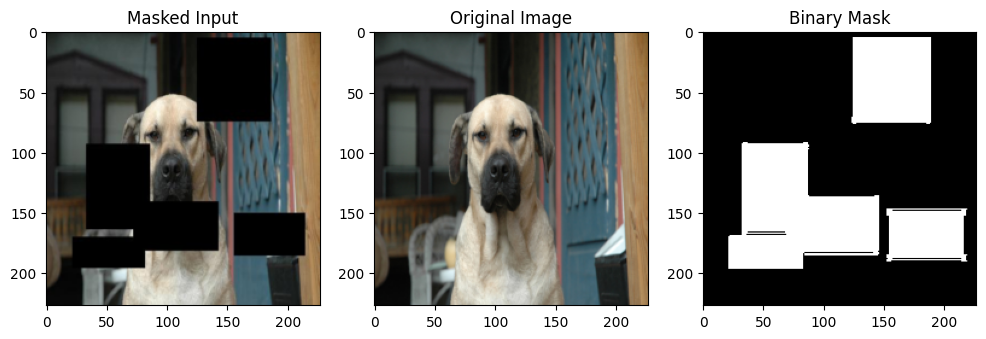

In [42]:
# visual verification of the dataset

import matplotlib.pyplot as plt

def show_sample(sample):
    masked = sample['masked'].permute(1, 2, 0).numpy()
    original = sample['original'].permute(1, 2, 0).numpy()
    mask = sample['mask'][0].numpy()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(masked)
    plt.title('Masked Input')

    plt.subplot(1, 3, 2)
    plt.imshow(original)
    plt.title('Original Image')

    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap='gray')
    plt.title('Binary Mask')

    plt.show()

# Run it on first sample
show_sample(sample)
